# Zadatak 2

U izradi ovog zadatka biće korišćen CIFAR-10 dataset. CIFAR-10 sadrži 60000 32x32 slika u boji, koje su podeljene u 10 klasa, gde svaka od klasa ima po 6000 slika. 50000 slika spada u trening, dok je 10000 u test skupu. Trening skup će naknadno biti podeljen na trening i validacioni. Zadatak je klasifikovati sliku u odgovarajuću klasu. Klase su:
- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck

Među klasama ne postoji preklapanje.

In [2]:
import os
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchsummary import summary

In [3]:
torch.backends.cudnn.benchmark = True

### Učitavanje dataset-a

In [4]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = batch[b'data']
    labels = batch[b'labels']
    
    data = data.reshape(-1, 3, 32, 32)   
    data = data.transpose(0, 2, 3, 1)  
    return data, np.array(labels)
    

def load_cifar10(path):
    xs = [] 
    ys = []
    
    for i in range(1, 6):
        batch_file = os.path.join(path, f"data_batch_{i}")
        X, Y = load_batch(batch_file)
        xs.append(X)
        ys.append(Y)
    
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    
    X_test, Y_test = load_batch(os.path.join(path, "test_batch"))
    
    return X_train, Y_train, X_test, Y_test


def load_label_names(path):
    with open(os.path.join(path, "batches.meta"), 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    return [label.decode("utf-8") for label in meta[b'label_names']]
    

path = r"cifar-10-python\cifar-10-batches-py"

classes = load_label_names(path)
X, Y, X_te, Y_te = load_cifar10(path)
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"Trening set: \n \t dimenzije ulaza  {X_tr.shape} \n \t dimenzije izlaza {Y_tr.shape}")
print(f"Validacioni set: \n \t dimenzije ulaza  {X_val.shape} \n \t dimenzije izlaza {Y_val.shape}")
print(f"Test set: \n \t dimenzije ulaza  {X_te.shape} \n \t dimenzije izlaza {Y_te.shape}")

Trening set: 
 	 dimenzije ulaza  (40000, 32, 32, 3) 
 	 dimenzije izlaza (40000,)
Validacioni set: 
 	 dimenzije ulaza  (10000, 32, 32, 3) 
 	 dimenzije izlaza (10000,)
Test set: 
 	 dimenzije ulaza  (10000, 32, 32, 3) 
 	 dimenzije izlaza (10000,)


### Primeri klasa

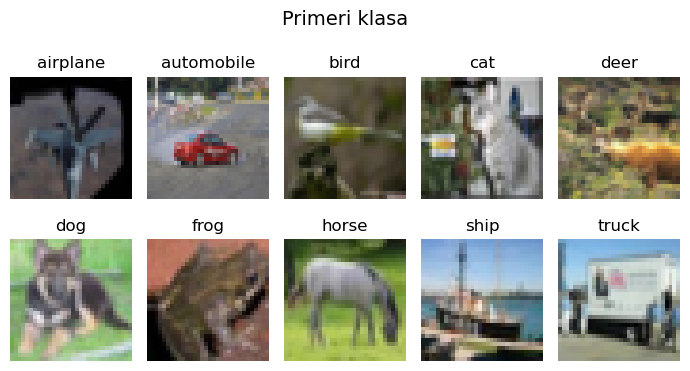

In [5]:
imgs = []
for i in range(10):
    idxs = np.where(Y == i)[0]
    imgs.append(X[idxs[10]])

fig, axes = plt.subplots(2, 5, figsize=(7, 4))
fig.suptitle("Primeri klasa", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.set_title(classes[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


Zbog male rezolucije slika (32x32) slike izgledaju dosta zamućeno, međutim mogu se jasno uočiti objeti od interesa na slici, kao i to da ne postoji preklapanja klasa (na primer na slici sa mačkom ne postoji i pas pored nje).

### Prikaz broja odbiraka po klasama

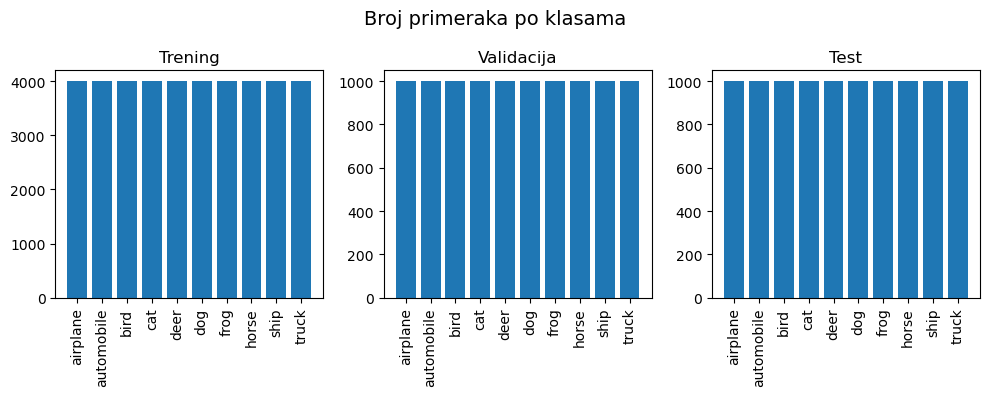

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("Broj primeraka po klasama", fontsize=14)
axes = axes.flat

c_labels = [i for i in range(10)]
num_samples_train = [np.sum(Y_tr == c) for c in c_labels]
num_samples_val = [np.sum(Y_val == i) for c in c_labels]
num_samples_test = [np.sum(Y_te == i) for c in c_labels]

axes[0].bar(c_labels, num_samples_train)
axes[0].set_title("Trening") 
    
axes[1].bar(c_labels, num_samples_val)
axes[1].set_title("Validacija")

axes[2].bar(c_labels, num_samples_test)
axes[2].set_title("Test")

for ax in axes:
    ax.set_xticks(c_labels)
    ax.set_xticklabels(classes, rotation=90)
    
plt.xticks(c_labels, classes)
plt.tight_layout()
plt.show()

Uočavamo da su sve klase podjednako zastupljene u svim skupovima.

### Preprocesiranje podataka

Sada je potrebno izvršiti preprocesiranje slika. Ovo je korak koji bi trebalo da obezbedi efikasnije obučavanje modela. 

Ovo uključuje normalizaciju koja normalizuje vrednosti po kanalima tako da budu raspodeljene oko nule sa jediničnom standardnom devijaciom. Na ovaj način se obezbeđuje da se svi ulazni podaci nalaze u sličnim opsezima, čime se ubrzava konvergencija tokom treniranja i smanjuje rizik da mreža upadne u oblasti saturacije aktivacionih funkcija. Normalizacija doprinosi stabilnijem i bržem učenju modela.

Zatim treba izvršiti i augmentaciju. Augmentacija će se izvršavati samo na trening podacima. Uloga augmentacije je da spreči preobučavanje mreže, tako što će na neki način da unese izmene u originalne slike i tako unese dodatnu varijabilnost prilikom. Na ovaj način mreža u svakoj epohi vidi malo drugačiju sliku nego ranije, pa samim tim se otežava učenje slika napamet. Za augmentaciju su ovde korišćene:
- Obrtanje slike po horizontalnoj osi - tera mrežu da postane otporna na to na koju starnu gledaju objekti (nije i po vertikalnoj zato što to nema nekog smisla - retko će se desiti da se nađe neka slika proda "naglavačke")
- Nasumično kropovanje slike - omogućava da mreža nauči da se prillagodi na slučajeve kad objekti nisu savršeno centrirani ili su delimično isečeni
- Rotacija (za do 10 stepeni) - simulira situacije kada su objekti blago nagnuti ili nakošeni na slici

Ove metode obezbežuju veću robusnost modela.

In [7]:
Xmean = X_tr.mean(axis=(0,1,2)) / 255.0
Xstd  = X_tr.std(axis=(0,1,2)) / 255.0

mean = tuple(Xmean.astype("float32"))
std  = tuple(Xstd.astype("float32"))

In [8]:
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.Y[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform_train = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

transform_test = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                std=(0.247, 0.243, 0.261))
])

train_ds = MyDataset(X_tr, Y_tr, transform=transform_train)
val_ds   = MyDataset(X_val, Y_val, transform=transform_test)
test_ds  = MyDataset(X_te, Y_te, transform=transform_test)


train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)


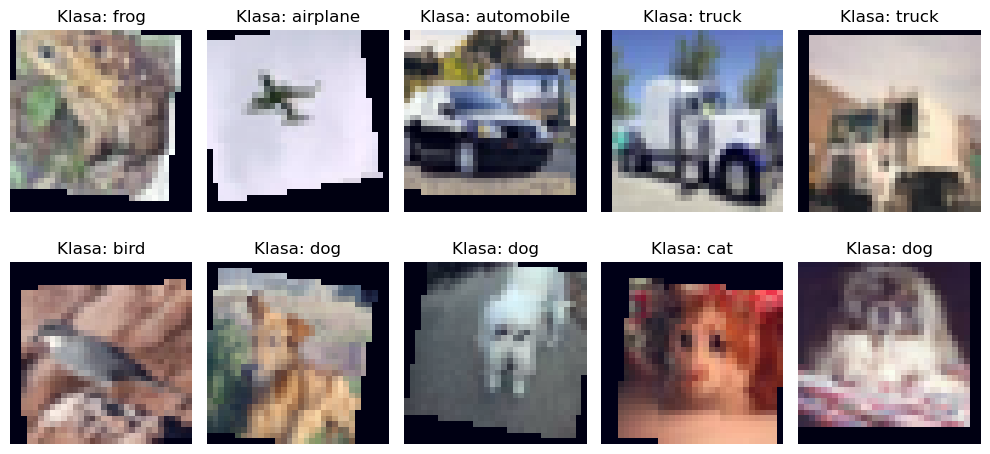

In [9]:
images, labels = next(iter(train_loader)) 

fig, axes = plt.subplots(2, 5, figsize=(10,5))
for i, ax in enumerate(axes.flat):
    img = images[i].numpy().transpose(1,2,0) 
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.set_title(f"Klasa: {classes[int(labels[i])]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Arhitektrua modela

Arhitektura modela:
- Konvolucija $3 \times 3$, broj filtera = 32 stride=1
- Konvolucija $3 \times 3$, broj filtera = 32 stride=1
- Max Pool $2 \times 2$, stride=2
- Konvolucija $3 \times 3$, broj filtera = 64 stride=1
- Konvolucija $3 \times 3$, broj filtera = 64 stride=1
- Max Pool $2 \times 2$, stride=2
- Konvolucija $3 \times 3$, broj filtera = 64 stride=1
- Konvolucija $3 \times 3$, broj filtera = 64 stride=1
- Max Pool $2 \times 2$, stride=2
- Flatten sloj
- Potpuno povezani sloj sa 2048 ulaza i 512 izlaza
- Potpuno povezani sloj sa 512 ulaza i 10 (broj klasa) izlaza
- Softmax

Implementirana je i rezidualna konekcija radi bolje propagacije gradijenta. Koristi se ReLU aktivaciona funkcija, a pre nje se primenjuje BatchNorm normalizujući sloj.

**Kriterijumska funkcija**: Cross Entropy Loss. Ova funkcija se uobičajeno koristi kod problema višeklasne klasifikacije kao što je to ovde slučaj. Funkcija prima prediktovane verovatnoće klasa (izlat softmax sloja) i penalizuje male verovatnoće za željeni izlaz (t.j. što je manja verovatnoća za datu labelu to će vrednost loss-a biti veći) primenjujući negativni logaritam. $$L_i = -log(p(y_i))$$ $$Loss = \frac{1}{N} \sum_{i=1}^N L_i$$
Kada mreža napravi lošu predikciju, izvod je veliki, pa ovaka losss funkcija omogućava da imamo relativno veliki korak pri gradient descent algoritmu i time brđe stignemo do bolje predikcije.

**Funkcija aktivacije**: ReLU. ReLU rešava probleme koje su sigmoid i tanh funkcije imale. Ova funkcija je deo po deo linearna, međutim u celosti je nelinerna, tako da unosi nelinearnost u naš model. U pozitivnom delu ima konstantan, veliki gradijent, koji iznosi 1 i nema zasićenje, te nam garantuje bržu konvergenciju eliminišući problem nestajućih gradijenata. Jedina mana je mrtva zona u negativno delu, ukoliko ovo kvari performanse mreže mogu se koristiti i funkcije kao LeakyReLU ili GeLU. $$f(x) = \max(0, x)$$

Kao aktivacija na izlaznom sloju se koristi softmax. Ovaj sloj je pogodan da se koristi kao izlaz mreže kod problema višeklasne klasifikacije, a naročito u kombinaciji sa Cross Entropy Loss funckijom. Ovaj sloj ima tu osobinu da zbir svih izlaza daje 1, a da svaki pojedinačni izlaz pripada opsegu od 0 do 1. Dakle, izlazi se mogu tumačiti kao verovatnoće da dati odbirak pripada odgovarajućim kalsama. $$p(y_i = k) = \frac{e^{s_k}}{\sum_{i=1}^{N}e^{s_i}}, \quad s_i \text{ predstavljaju ulaze u softmax}$$

**Optimizator** : AdamW. AdamW koristi gradient descent metodu optimizacije, kombinovanu sa adaptivnim nalaženjem konstante učenja i momentumom. Takođe omogućava i L2 regularizaciju dodajući penalty term na originalnu loss funkciju: $$Loss_u = Loss + \alpha\sum_i w_i^2$$ Ovo omogućava bolju regularizaciju i bržu konvergenciju u odnosu na Adam.

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

In [11]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(3, 32),
            nn.MaxPool2d(2) 
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageClassifier().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
            Conv2d-6           [-1, 32, 32, 32]              96
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
     ResidualBlock-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,432
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

### Obučavanje mreže

In [13]:
def train_model(model, optimizer, scheduler, train_loader, val_loader, num_epochs=1, patience=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.0
    best_model = None
    no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoha {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0
        running_corrects = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(images)
            loss = F.cross_entropy(logits, labels, label_smoothing=0.05)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = logits.max(1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)


        model.eval()
        val_loss = 0
        val_corrects = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                logits = model(images)
                loss = F.cross_entropy(logits, labels, label_smoothing=0.05)

                val_loss += loss.item() * images.size(0)
                _, preds = logits.max(1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping u epohi {epoch+1}")
                break

    model.load_state_dict(best_model)

    return model, history


Epoha 1/100
Train Loss: 1.7461 Acc: 0.3861
Val   Loss: 1.5031 Acc: 0.5133

Epoha 2/100
Train Loss: 1.4406 Acc: 0.5241
Val   Loss: 1.2717 Acc: 0.5930

Epoha 3/100
Train Loss: 1.2946 Acc: 0.5938
Val   Loss: 1.1545 Acc: 0.6466

Epoha 4/100
Train Loss: 1.1983 Acc: 0.6371
Val   Loss: 1.0617 Acc: 0.6891

Epoha 5/100
Train Loss: 1.1275 Acc: 0.6706
Val   Loss: 0.9636 Acc: 0.7309

Epoha 6/100
Train Loss: 1.0709 Acc: 0.6955
Val   Loss: 0.9346 Acc: 0.7486

Epoha 7/100
Train Loss: 1.0353 Acc: 0.7140
Val   Loss: 0.9304 Acc: 0.7501

Epoha 8/100
Train Loss: 0.9916 Acc: 0.7300
Val   Loss: 0.9082 Acc: 0.7591

Epoha 9/100
Train Loss: 0.9697 Acc: 0.7407
Val   Loss: 0.8453 Acc: 0.7868

Epoha 10/100
Train Loss: 0.9372 Acc: 0.7550
Val   Loss: 0.8975 Acc: 0.7682

Epoha 11/100
Train Loss: 0.9154 Acc: 0.7653
Val   Loss: 0.8285 Acc: 0.7912

Epoha 12/100
Train Loss: 0.8898 Acc: 0.7752
Val   Loss: 0.8092 Acc: 0.8042

Epoha 13/100
Train Loss: 0.8759 Acc: 0.7814
Val   Loss: 0.7817 Acc: 0.8146

Epoha 14/100
Train L

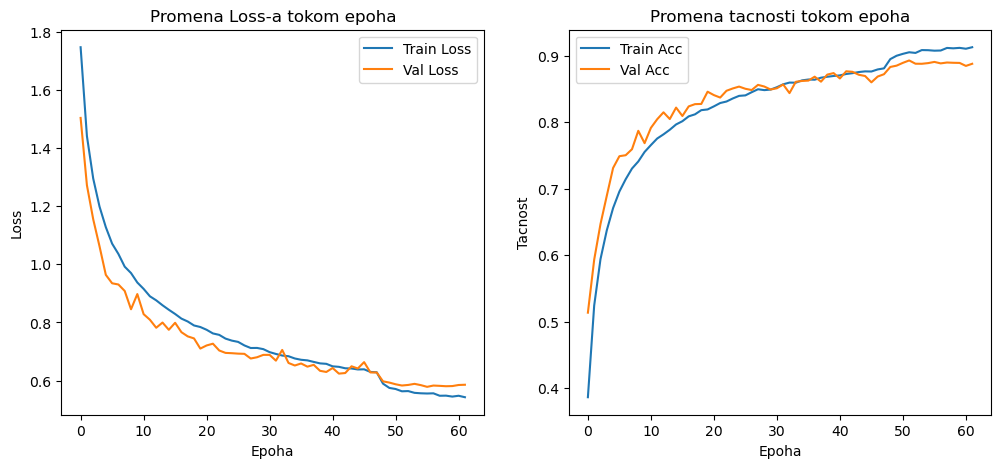

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5)

model, history = train_model(model, optimizer, scheduler, train_loader, val_loader, num_epochs=100, patience=10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoha")
plt.ylabel("Loss")
plt.legend()
plt.title("Promena Loss-a tokom epoha")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoha")
plt.ylabel("Tacnost")
plt.legend()
plt.title("Promena tacnosti tokom epoha")
plt.show()

Loss krive i na trening i na test skupu imaju zadovoljavajući oblik. Zbog primene early stopping-a kada je loss krenuo da raste na val skupu došlo je do zaustavljanja obučavanja, kako ne bi došlo do preobučavanja, i vraćen je model sa najboljim loss-om na validacionom skupu.

### Evaluacija na trening skupu

In [15]:
def evaluate_model(model, loader, classes, name):
    model.eval()
    my_preds = []
    my_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, preds = logits.max(1)
            my_preds.extend(preds.cpu().numpy())
            my_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(my_labels, my_preds)
    prec = precision_score(my_labels, my_preds, average="weighted")
    rec = recall_score(my_labels, my_preds, average="weighted")
    f1 = f1_score(my_labels, my_preds, average="weighted")

    print(f"\nRezultati za {name} skup:")
    print(f"Tačnost    : {acc:.4f}")
    print(f"Preciznost : {prec:.4f}")
    print(f"Osetljivost: {rec:.4f}")
    print(f"F1-skor    : {f1:.4f}")

    cm = confusion_matrix(my_labels, my_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title(f"Konfuziona matrica za {name} skup")
    plt.xlabel("Predikcija")
    plt.ylabel("Istina")
    plt.show()


Rezultati za trening skup:
Tačnost    : 0.9338
Preciznost : 0.9343
Osetljivost: 0.9338
F1-skor    : 0.9339


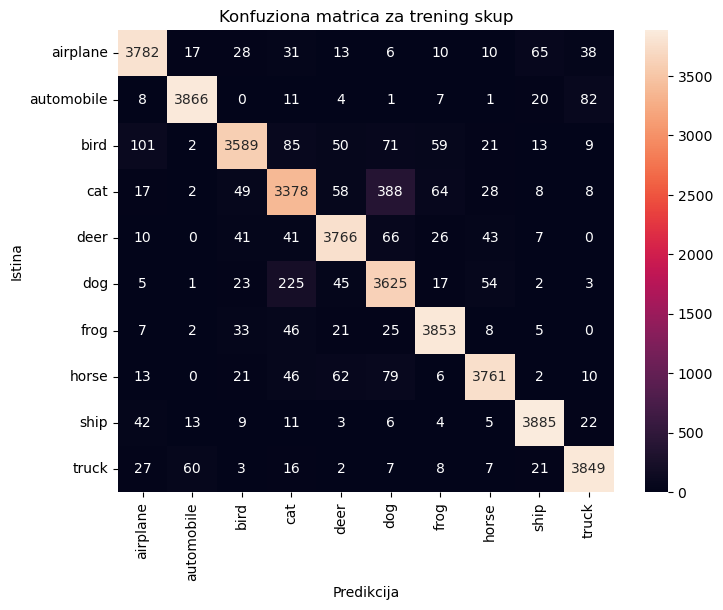

In [16]:
evaluate_model(model, train_loader, classes, name="trening")

### Evaluacija na test skupu


Rezultati za test skup:
Tačnost    : 0.8872
Preciznost : 0.8881
Osetljivost: 0.8872
F1-skor    : 0.8871


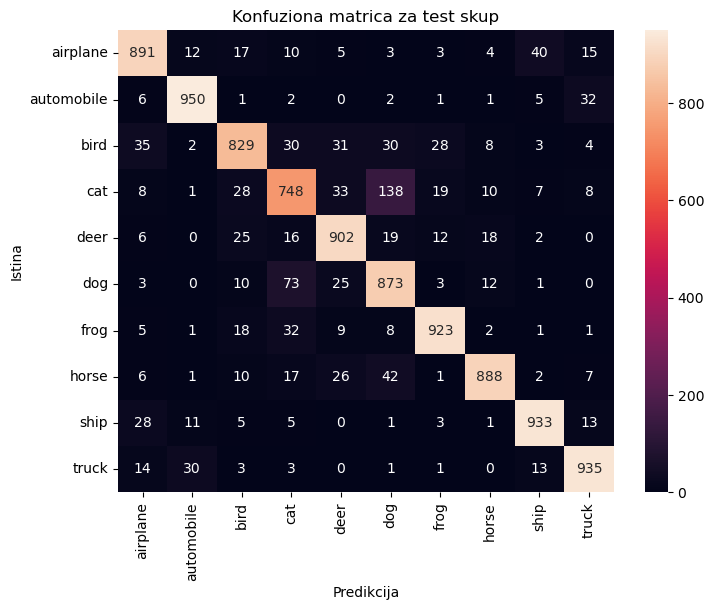

In [17]:
evaluate_model(model, test_loader, classes, name="test")

Kao što je i očekivano tačnost je nešto bolja na trening nego na test skupu, ali je razlika samo oko 4%. Ukoliko bismo želeli da ovu razliku smanjimo moguće je primeniti malo agresivniju regluarizaciju. Bitno je istaći da su svi parametri: tačnost, preciznost, recall i f-score približno jednaki.

Model je u glavnom pri lošim klasifikacijama mešao međusobno živtinje, ili međusobno objekte, jedini značajniji izuzetak je to što se često dešavalo da model meša klasu bird i ariplane, mada je ovo sasvim razumljivo. Još neke interesante opaske su da je model često mešao psa i mačku, kao i psa i konja, takođe i klase car i truck.

### Prikaz dobro i lose klasifikovanih slika

In [18]:
def plot_examples(examples, suptitle, n):
        fig, axes = plt.subplots(1, n, figsize=(15,3))
        fig.suptitle(suptitle, fontsize=14)
        for ax, (img, pred, true) in zip(axes, examples):
            img = img.permute(1,2,0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            ax.imshow(img)
            ax.set_title(f"T:{classes[true]}\nP:{classes[pred]}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

def show_examples(model, loader, classes, n=5):
    model.eval()
    good = []
    bad = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, preds = logits.max(1)
            for img, pred, true in zip(images, preds, labels):
                if pred == true and len(good) < n:
                    good.append((img.cpu(), pred.item(), true.item()))
                elif pred != true and len(bad) < n:
                    bad.append((img.cpu(), pred.item(), true.item()))
            if len(good) >= n and len(bad) >= n:
                break

    plot_examples(good, "Dobro Klasifikovani", n)
    plot_examples(bad, "Lose klasifikovani", n)

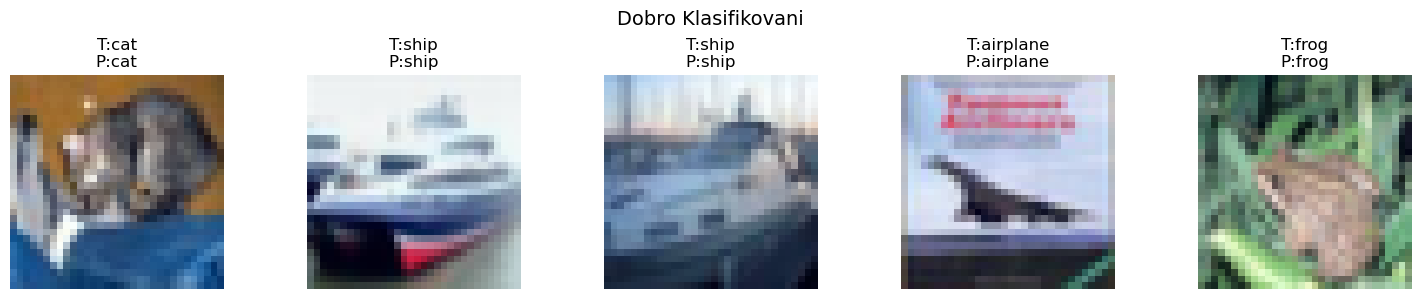

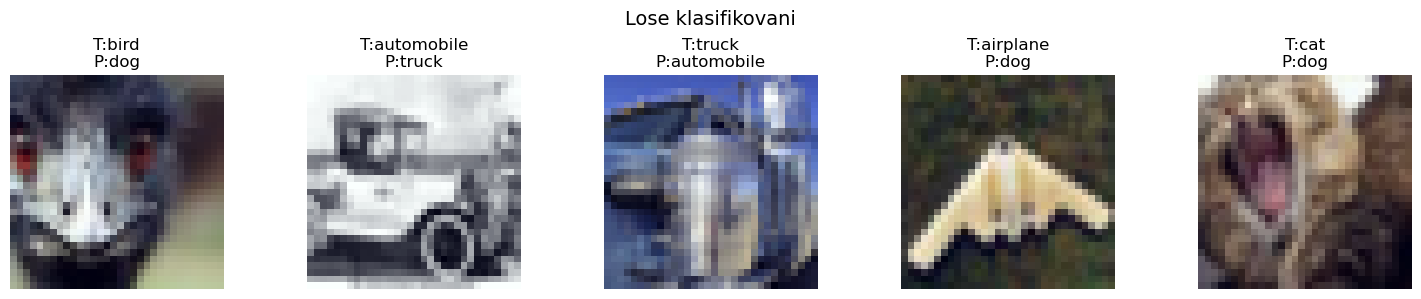

In [19]:
show_examples(model, test_loader, classes, n=5)